<a href="https://colab.research.google.com/github/HuiLinFDU/cruisefetch/blob/main/Rollup_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Python Script for Capstone Project
TASK 01: convert log data
Extract useful statistics from log files

In [ ]:
#==============================================================================#
# Capstone Project - Rollup for Pythia optimization
#   Function:
#      1. Read logfile(*.out) to generate Metadata(csv) used for statistics
#      2. Make charts based on statistics
#   Author: 25VS CSCI6806 V1 Group5
#
# [Note:] Please create folder /logfiles first when run in colab.
#==============================================================================#

import re
import csv
import os
import pandas as pd

# Function to extract core data from a log file
def extract_core_data(log_file_path):
    core_data = {}
    with open(log_file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('adding L2C_PREFETCHER:'):
                parts = line.strip().split()
                # Check if there are enough parts to get the prefetcher name
                if len(parts) > 2:
                    prefetcher = parts[2]
                    # adjust prefetcher's name
                    if prefetcher == 'Scooby':
                        prefetcher = 'Pythia'
                    elif prefetcher == 'SPP_dev2':
                        prefetcher = 'SPP'
                    elif prefetcher == 'NONE':
                        prefetcher = 'Nopref'
                    elif prefetcher == 'SPP_PPF_dev':
                        prefetcher = 'PPF'
                    core_data['Prefetcher'] = prefetcher

            if line.startswith('Core_0'):
                parts = line.strip().split()
                key = parts[0]
                value = parts[1] if len(parts) > 1 else None
                # Handle -nan string
                if value == '-nan':
                    value = 0
                try:
                    # Try to convert the value to a float, keep it as a string if conversion fails
                    value = float(value)
                except ValueError:
                    pass
                core_data[key] = value

    return core_data


# Function to save data from multiple log files to a CSV file
def save_multiple_logs_to_csv(log_files, csv_file_path, columns):
    all_data = []
    all_keys = set()

    # Extract data from all log files and combine keys
    for log_file in log_files:
        data = extract_core_data(log_file)
        # Add the log file name as the first column of data
        base_name = os.path.basename(log_file)
#       file_name = os.path.splitext(base_name)[0]
        file_name = base_name.split("_")[0] + "_" + base_name.split("_")[1]
        data['Trace'] = file_name
        all_data.append(data)
        all_keys.update(data.keys())

    # Ensure that only columns in the list are included
    sorted_keys = [col for col in columns if col in all_keys]

    df = pd.DataFrame(all_data)

    with open(csv_file_path, 'w', newline='', encoding='utf - 8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=sorted_keys)
        writer.writeheader()

        # Write each row of data
        for data in all_data:
            row = {key: data.get(key, '') for key in sorted_keys}
            writer.writerow(row)


if __name__ == "__main__":
    # Specify the directory path
    log_directory = '/content/sample_data/logfiles'
    # Get all .out files in the directory
    log_files = [os.path.join(log_directory, f) for f in os.listdir(log_directory) if f.endswith('.out')]

    csv_file_path = '/content/sample_data/log_statistics.csv'
    # List of columns to export
    columns = ['Trace', 'Prefetcher', 'Core_0_IPC','Core_0_branch_MPKI','Core_0_branch_prediction_accuracy','Core_0_instructions',
               'Core_0_L1D_average_miss_latency','Core_0_L1D_prefetch_dropped','Core_0_L1D_prefetch_filled','Core_0_L1D_prefetch_issued','Core_0_L1D_prefetch_useful','Core_0_L1D_prefetch_useless','Core_0_L1D_total_access','Core_0_L1D_total_miss',
               'Core_0_L2C_average_miss_latency','Core_0_L2C_prefetch_dropped','Core_0_L2C_prefetch_filled','Core_0_L2C_prefetch_issued','Core_0_L2C_prefetch_useful','Core_0_L2C_prefetch_useless','Core_0_L2C_total_access','Core_0_L2C_total_miss',
               'Core_0_LLC_average_miss_latency','Core_0_LLC_prefetch_dropped','Core_0_LLC_prefetch_filled','Core_0_LLC_prefetch_issued','Core_0_LLC_prefetch_useful','Core_0_LLC_prefetch_useless','Core_0_LLC_total_access','Core_0_LLC_total_miss'
               ]

    save_multiple_logs_to_csv(log_files, csv_file_path, columns)


TASK 02: Evaluation indicator calculation

In [ ]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('/content/sample_data/log_statistics.csv')


# Calculate new columns with handling division by zero
df['L1D_Miss_Rate'] = np.where(df['Core_0_L1D_total_access'] == 0, 0, df['Core_0_L1D_total_miss'] / df['Core_0_L1D_total_access'])
df['L2C_Miss_Rate'] = np.where(df['Core_0_L2C_total_access'] == 0, 0, df['Core_0_L2C_total_miss'] / df['Core_0_L2C_total_access'])
df['LLC_Miss_Rate'] = np.where(df['Core_0_LLC_total_access'] == 0, 0, df['Core_0_LLC_total_miss'] / df['Core_0_LLC_total_access'])

#df['L1D_Prefetch_Accuracy'] = df['Core_0_L1D_prefetch_useful'].div(df['Core_0_L1D_prefetch_issued'], fill_value=0)
#df['L2C_Prefetch_Accuracy'] = df['Core_0_L2C_prefetch_useful'].div(df['Core_0_L2C_prefetch_issued'], fill_value=0)
#df['LLC_Prefetch_Accuracy'] = df['Core_0_LLC_prefetch_useful'].div(df['Core_0_LLC_prefetch_issued'], fill_value=0)
df['L1D_Prefetch_Accuracy'] = np.where(df['Core_0_L1D_prefetch_issued'] == 0, 0, df['Core_0_L1D_prefetch_useful'] / df['Core_0_L1D_prefetch_issued'])
df['L2C_Prefetch_Accuracy'] = np.where(df['Core_0_L2C_prefetch_issued'] == 0, 0, df['Core_0_L2C_prefetch_useful'] / df['Core_0_L2C_prefetch_issued'])
df['LLC_Prefetch_Accuracy'] = np.where(df['Core_0_LLC_prefetch_issued'] == 0, 0, df['Core_0_LLC_prefetch_useful'] / df['Core_0_LLC_prefetch_issued'])


df['L1D_Prefetch_Overhead'] = np.where(df['Core_0_instructions'] == 0, 0, df['Core_0_L1D_prefetch_issued'] / df['Core_0_instructions'])
df['L2C_Prefetch_Overhead'] = np.where(df['Core_0_instructions'] == 0, 0, df['Core_0_L2C_prefetch_issued'] / df['Core_0_instructions'])
df['LLC_Prefetch_Overhead'] = np.where(df['Core_0_instructions'] == 0, 0, df['Core_0_LLC_prefetch_issued'] / df['Core_0_instructions'])

df['L1D_Coverage'] = np.where(df['Core_0_L1D_total_miss'] == 0, 0, df['Core_0_L1D_prefetch_useful'] / df['Core_0_L1D_total_miss'])
df['L2C_Coverage'] = np.where(df['Core_0_L2C_total_miss'] == 0, 0, df['Core_0_L2C_prefetch_useful'] / df['Core_0_L2C_total_miss'])
df['LLC_Coverage'] = np.where(df['Core_0_LLC_total_miss'] == 0, 0, df['Core_0_LLC_prefetch_useful'] / df['Core_0_LLC_total_miss'])

df['L1D_Uncovered_Misses'] = df['Core_0_L1D_total_miss'] - df['Core_0_L1D_prefetch_useful']
df['L2C_Uncovered_Misses'] = df['Core_0_L2C_total_miss'] - df['Core_0_L2C_prefetch_useful']
df['LLC_Uncovered_Misses'] = df['Core_0_LLC_total_miss'] - df['Core_0_LLC_prefetch_useful']

#df['L1D_Overprediction'] = df['Core_0_L1D_prefetch_useless'].div(df['Core_0_L1D_prefetch_issued'], fill_value=0)
#df['L2C_Overprediction'] = df['Core_0_L2C_prefetch_useless'].div(df['Core_0_L2C_prefetch_issued'], fill_value=0)
#df['LLC_Overprediction'] = df['Core_0_LLC_prefetch_useless'].div(df['Core_0_LLC_prefetch_issued'], fill_value=0)
df['L1D_Overprediction'] = np.where(df['Core_0_L1D_prefetch_issued'] == 0, 0, df['Core_0_L1D_prefetch_useless'] / df['Core_0_L1D_prefetch_issued'])
df['L2C_Overprediction'] = np.where(df['Core_0_L2C_prefetch_issued'] == 0, 0, df['Core_0_L2C_prefetch_useless'] / df['Core_0_L2C_prefetch_issued'])
df['LLC_Overprediction'] = np.where(df['Core_0_LLC_prefetch_issued'] == 0, 0, df['Core_0_LLC_prefetch_useless'] / df['Core_0_LLC_prefetch_issued'])

#--- add indicator for figure 7
df['Covered'] = np.where(df['Core_0_LLC_total_miss'] == 0, 0, df['Core_0_LLC_prefetch_useful'] / df['Core_0_LLC_total_miss'])
df['Uncovered'] = np.where(df['Core_0_LLC_total_miss'] == 0, 0, (df['Core_0_LLC_total_miss'] - df['Core_0_LLC_prefetch_useful']) / df['Core_0_LLC_total_miss'])
df['Overpredicted'] = np.where(df['Core_0_LLC_total_miss'] == 0, 0, df['Core_0_LLC_prefetch_useless'] / df['Core_0_LLC_total_miss'])


# Save the updated DataFrame to a new CSV file
df.to_csv('/content/sample_data/allstats.csv', index=False)


TASK 03: Generate statistical charts refering to the paper

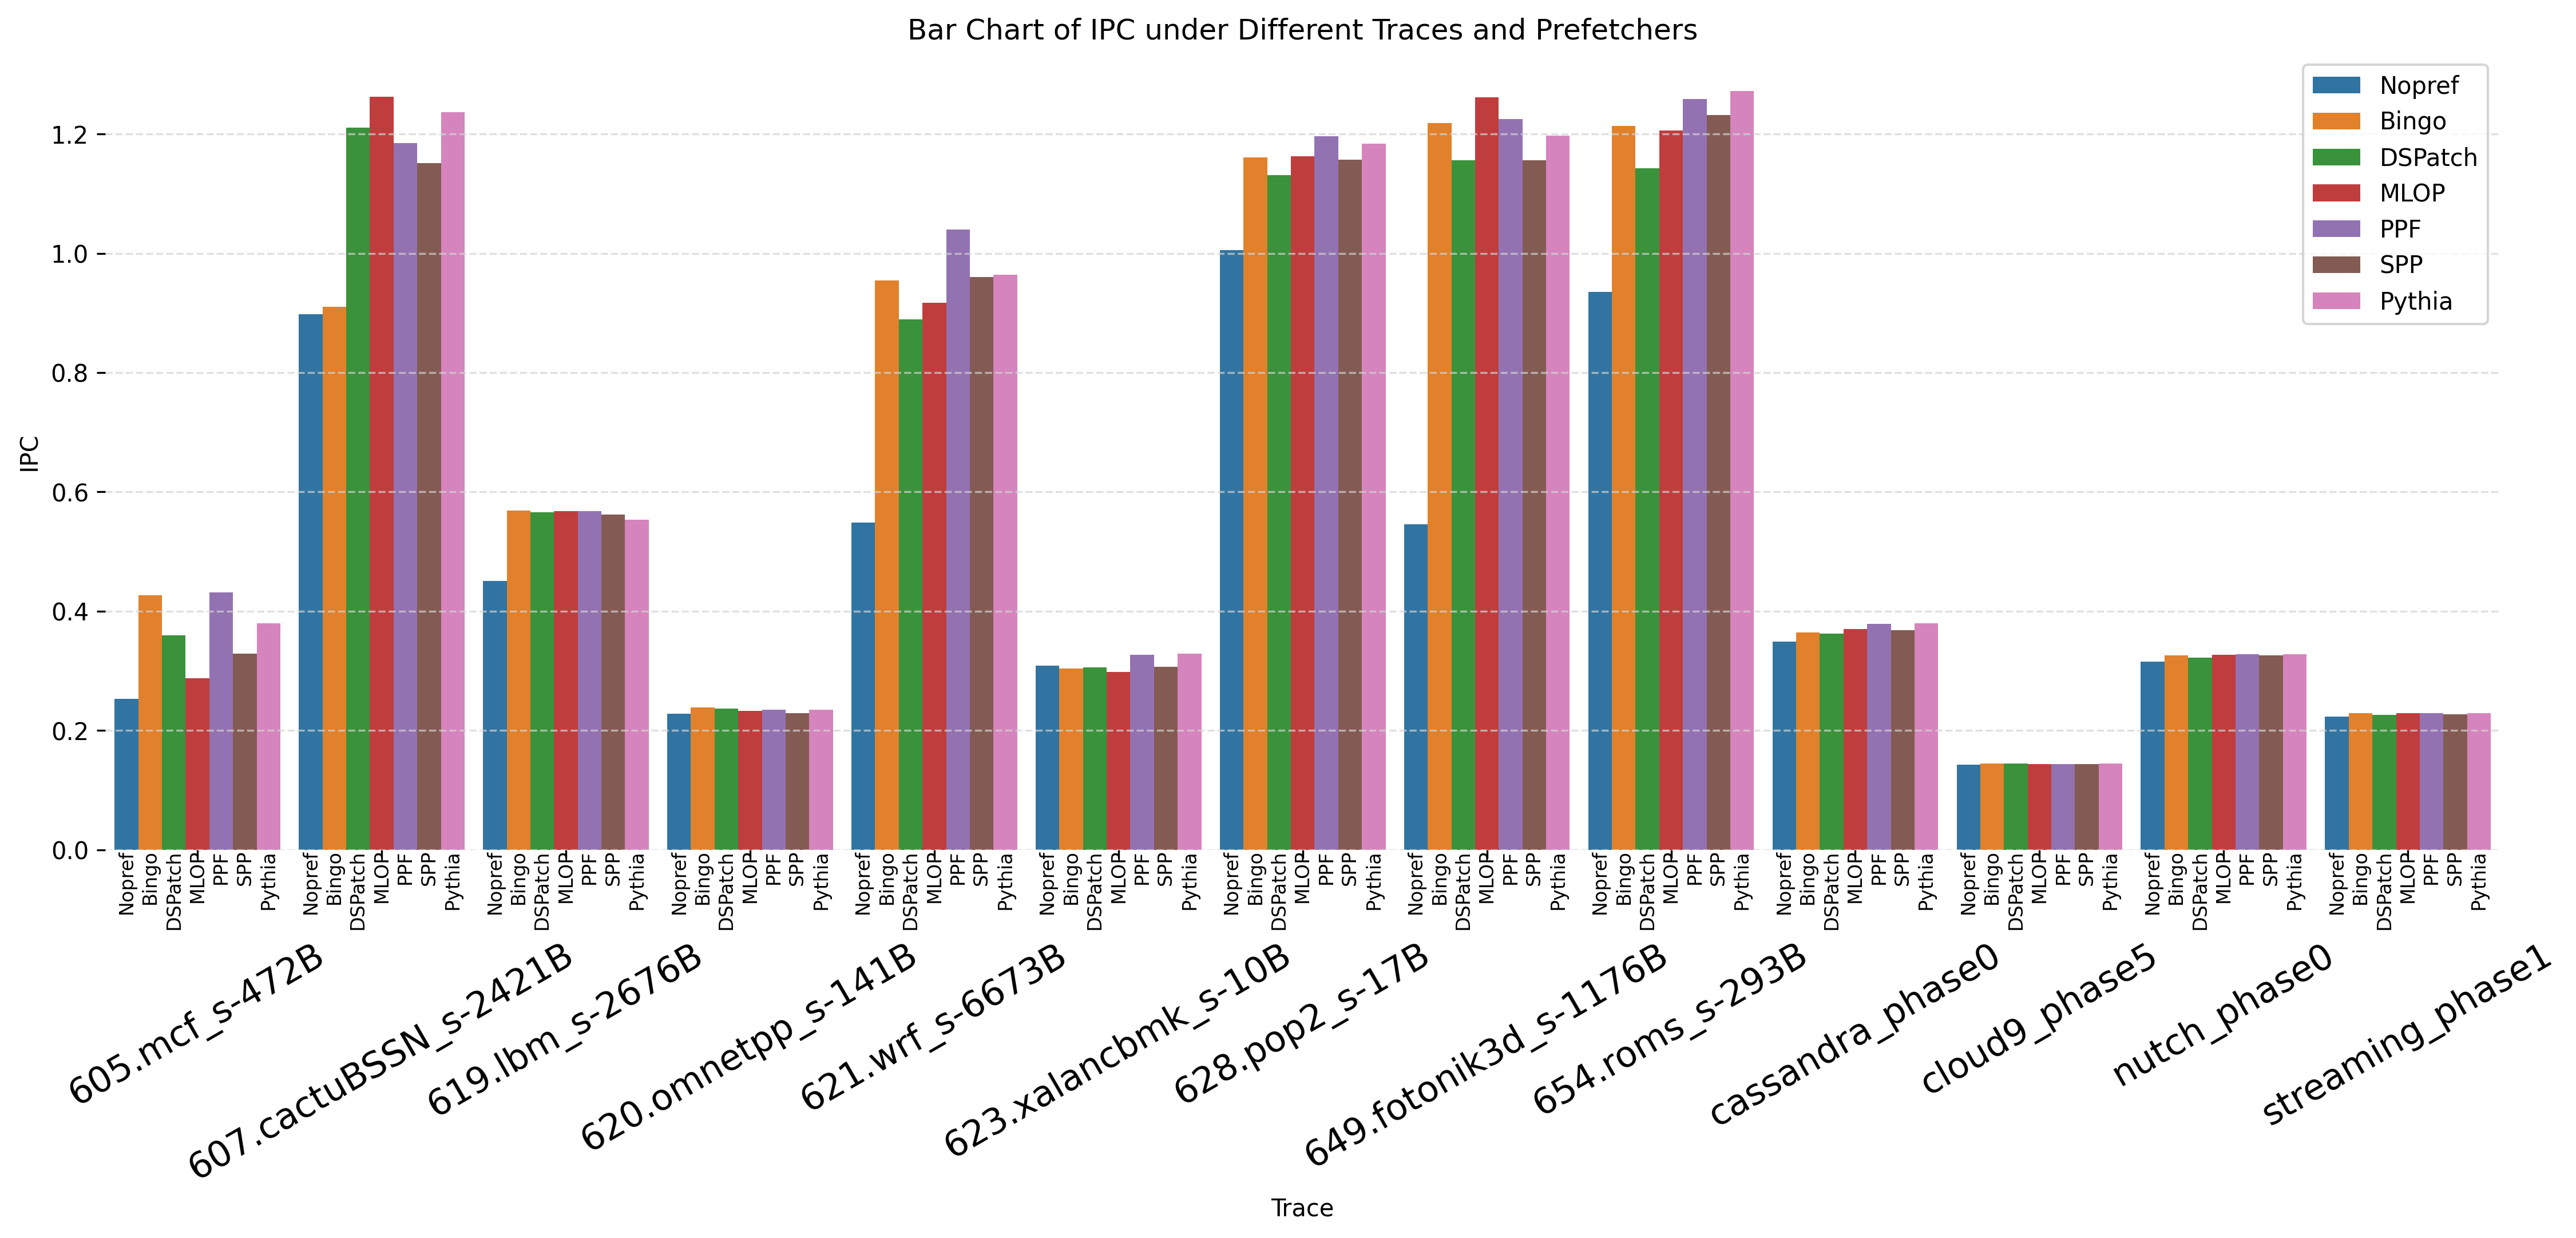

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Read the CSV file
df = pd.read_csv('/content/sample_data/allstats.csv')

# Set the figure resolution
plt.rcParams['figure.dpi'] = 300

# Set the figure size, increase the width to provide more space for labels
plt.figure(figsize=(18, 8))

# Define the order of Prefetcher
prefetcher_order = ['Nopref', 'Bingo', 'DSPatch', 'MLOP', 'PPF', 'SPP', 'Pythia']
df['Prefetcher'] = pd.Categorical(df['Prefetcher'], categories=prefetcher_order, ordered=True)

# Sort the DataFrame by Trace and then by Prefetcher
df = df.sort_values(by=['Trace', 'Prefetcher'])

# Plot the bar chart of Core_0_IPC grouped by Prefetcher
# Increase the width of the bar groups
bar_group_width = 0.9
bar_width = bar_group_width / len(df['Prefetcher'].unique())
ax = sns.barplot(data=df, x='Trace', y='Core_0_IPC', hue='Prefetcher', width=bar_group_width)

# Get unique traces and prefetchers
traces = df['Trace'].unique()
prefetchers = df['Prefetcher'].unique()
num_prefetchers = len(prefetchers)
num_traces = len(traces)

# Add vertical Prefetcher labels below each bar group
prefetcher_label_offset = 0  # Adjust this value to move Prefetcher labels up or down
for i, trace in enumerate(traces):
    for j, prefetcher in enumerate(prefetchers):
        bar_x = i - bar_group_width / 2 + (j + 0.5) * bar_width
        ax.text(bar_x, prefetcher_label_offset, prefetcher, ha='center', va='top', rotation=90, fontsize=8)

# Set the title and axis labels
plt.title('Bar Chart of IPC under Different Traces and Prefetchers')
plt.ylabel('IPC')

# Move Trace labels down and adjust font size
trace_label_offset = -0.1  # Adjust this value to move Trace labels up or down
plt.xticks(range(num_traces), traces, rotation=30, ha='center', va='top', fontsize=15)
plt.gca().tick_params(axis='x', pad=0)
for tick in ax.get_xticklabels():
    tick.set_y(trace_label_offset)

# Adjust the subplot to make room for labels
plt.subplots_adjust(bottom=0.3)

# Optimize the y-axis grid lines (dashed lines)
ax.yaxis.grid(True, linestyle='--', color='lightgray', alpha=0.7, linewidth=0.8)

# Remove the spines (borders) of the plot for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Display the legend
plt.legend()

# Display the plot
plt.show()

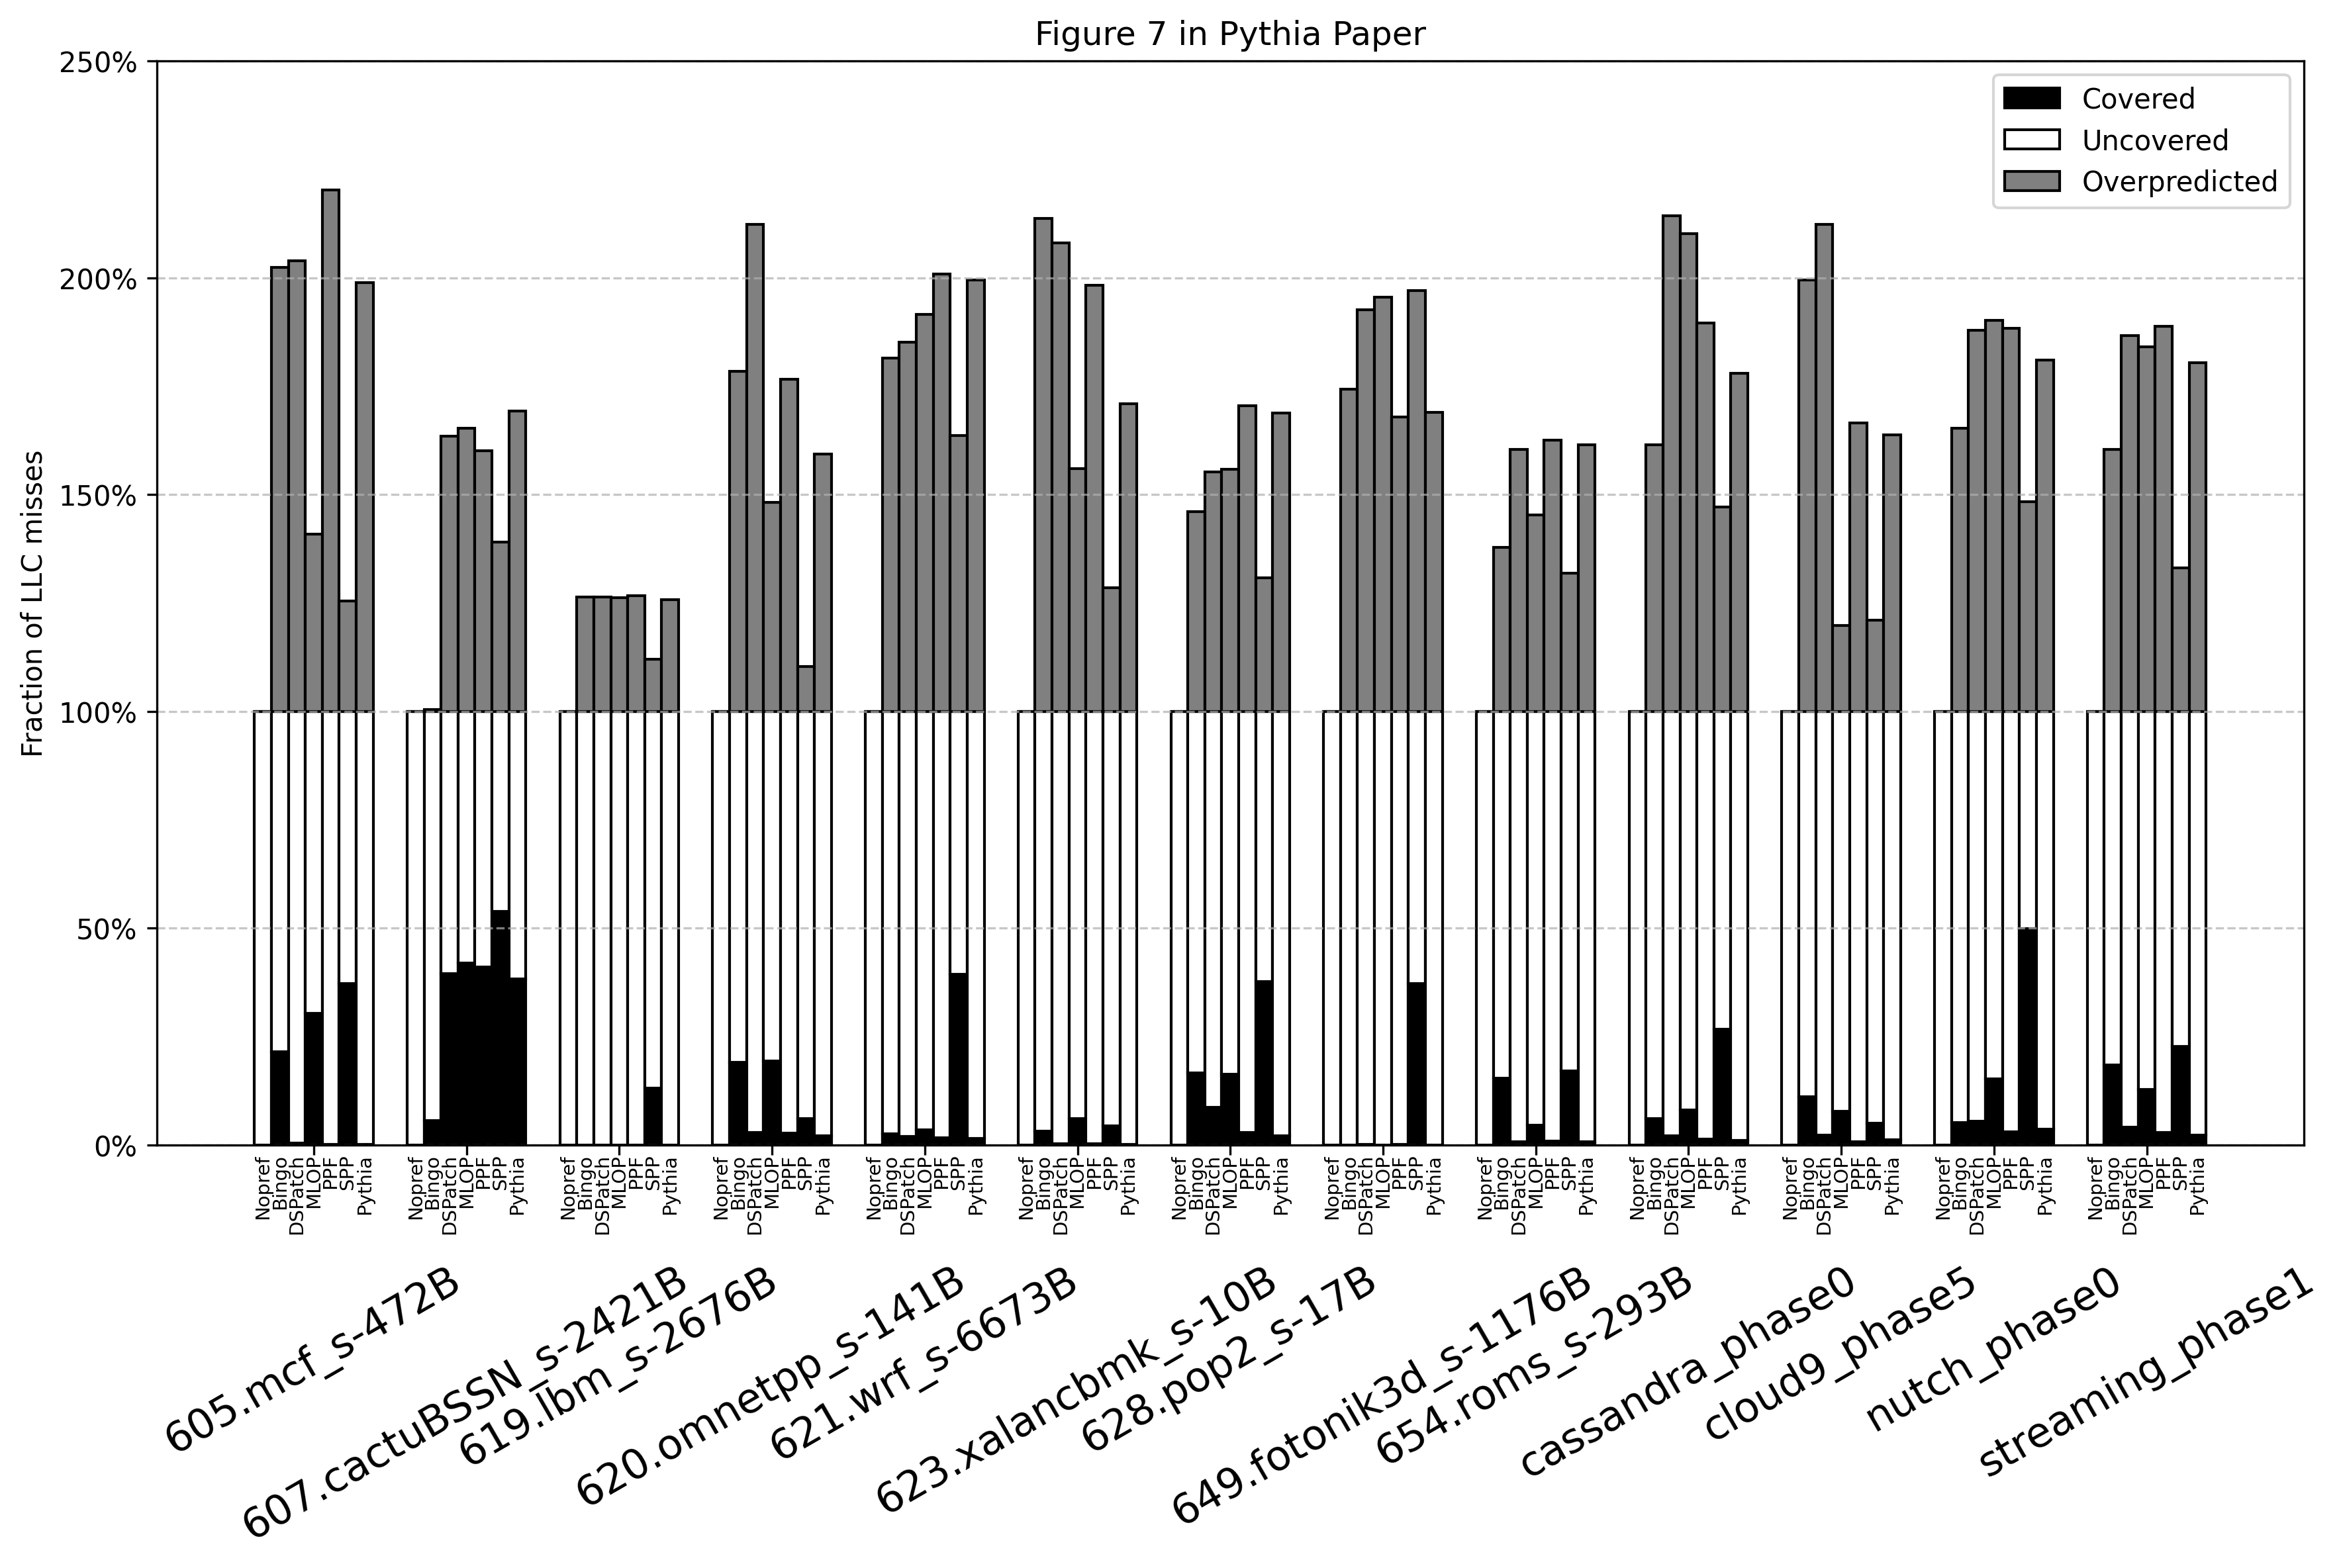

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = pd.read_csv('/content/sample_data/allstats.csv')

# 按 Trace 列进行排序
df = df.sort_values(by='Trace')

# Set the figure resolution
plt.rcParams['figure.dpi'] = 300

# Set font
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Get the unique values in the 'Trace' and 'Prefetcher' columns
traces = df['Trace'].unique()
num_traces = len(traces)

# Define the desired order of prefetchers
desired_prefetchers = ['Nopref', 'Bingo', 'DSPatch', 'MLOP', 'PPF', 'SPP', 'Pythia']
# Filter out the prefetchers that are actually in the data
prefetchers = [p for p in desired_prefetchers if p in df['Prefetcher'].unique()]
num_prefetchers = len(prefetchers)

# Width of each bar
bar_width = 0.25

# Gap between groups of bars
group_gap = 0.5

# Positions on the x-axis for each group of bars
x_groups = np.arange(num_traces) * (num_prefetchers * bar_width + group_gap)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Initialize max_value to track the maximum value of the stacked bars
max_value = 0

# Iterate over different prefetchers in the desired order
for i, prefetcher in enumerate(prefetchers):
    subset = df[df['Prefetcher'] == prefetcher]
    covered = subset['Covered'].values
    uncovered = subset['Uncovered'].values
    overpredicted = subset['Overpredicted'].values

    # Draw the stacked bar chart
    bottom = np.zeros(num_traces)
    ax.bar(x_groups + i * bar_width, covered, bar_width, label='Covered' if i == 0 else "", bottom=bottom, color='black', edgecolor='black')
    bottom += covered
    ax.bar(x_groups + i * bar_width, uncovered, bar_width, label='Uncovered' if i == 0 else "", bottom=bottom, color='white', edgecolor='black')
    bottom += uncovered
    ax.bar(x_groups + i * bar_width, overpredicted, bar_width, label='Overpredicted' if i == 0 else "", bottom=bottom, color='grey', edgecolor='black')

    # Update max_value
    total = covered + uncovered + overpredicted
    current_max = np.max(total)
    if current_max > max_value:
        max_value = current_max

# Add Prefetcher labels centered above each bar group
for i, trace in enumerate(traces):
    for j, prefetcher in enumerate(prefetchers):
        ax.text(x_groups[i] + j * bar_width, -0.02, prefetcher, ha='center', va='top', rotation=90, fontsize=7)

# Set the x-axis ticks and labels for Trace
# Set ticks at the center of each group of bars
ax.set_xticks(x_groups + bar_width * (num_prefetchers - 1) / 2)
# Add Trace labels below the Prefetcher labels
ax.set_xticklabels(traces, rotation=30, ha='center', fontsize=15)

# Adjust the subplot parameters to make more room for the labels
plt.subplots_adjust(bottom=0.3)

# Move the Trace labels further down
ax.tick_params(axis='x', which='major', pad=38)

# Set the y-axis ticks and labels
# Ensure max_value is at least 1 (100%)
max_value = max(max_value, 1)
# Round up max_value to the nearest multiple of 0.5
max_y = np.ceil(max_value * 2) / 2
y_ticks = np.arange(0, max_y + 0.5, 0.5)

ax.set_yticks(y_ticks)
ax.set_yticklabels(['{:,.0%}'.format(x) for x in y_ticks])

# Set the title and axis labels of the chart
ax.set_title('Figure 7 in Pythia Paper')
#ax.set_xlabel('Trace & Prefetcher')
ax.set_ylabel('Fraction of LLC misses')

# Display the legend
ax.legend()

# Add dashed gridlines for the y-axis
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()